In [1]:
import torch
from transformers import GPT2Tokenizer, GPT2LMHeadModel


In [7]:

# Load pre-trained model tokenizer and model
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2LMHeadModel.from_pretrained('gpt2', output_attentions=True)


# Load pre-trained model tokenizer (vocabulary)
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

# Load pre-trained model

# Encode some text (replace "Your text here" with your input text)
input_text = "My name is Clara and I am?"
input_ids = tokenizer.encode(input_text, return_tensors='pt')

# Predict the next token
outputs = model(input_ids)
predictions = outputs[0]

# Get the predicted next token
predicted_index = torch.argmax(predictions[:, -1, :], dim=-1)
predicted_token = tokenizer.decode(predicted_index)

print("Predicted token:", predicted_token)


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

Predicted token:  I


In [8]:
import random
random_seed = random.randint(0, 10000)
torch.manual_seed(random_seed)

# Encode some text (add your own text here)
input_text = "My name is Clara and I am"
input_ids = tokenizer.encode(input_text, return_tensors='pt')

# Create an attention mask for the inputs
attention_mask = torch.ones(input_ids.shape)

# Set the model to evaluation mode and disable gradient calculations
model.eval()
with torch.no_grad():
    # Generate predictions
    outputs = model.generate(input_ids,
                             max_length=40,  # Maximum length of the output text
                             num_return_sequences=1,  # Number of sentences to generate
                             #temperature=0.5,  # Lower is less random, higher is more random
                             # Number of highest probability tokens to keep for top-k filtering
                             #attention_mask=attention_mask,  # The attention mask
                             pad_token_id=tokenizer.eos_token_id
                            )  # Set pad token

# Decode and print the output text
generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
print(generated_text)

My name is Clara and I am a woman. I am a woman who is a woman. I am a woman who is a woman. I am a woman who is a woman. I am a


In [9]:

import nltk
from nltk.corpus import gutenberg
from nltk.tokenize import sent_tokenize

# Download necessary NLTK datasets
nltk.download('gutenberg')
nltk.download('punkt')

# Load text from a simple-language corpus
text = gutenberg.raw('melville-moby_dick.txt') # gutenberg.raw('austen-emma.txt')
sentences = sent_tokenize(text)

# Tokenize text into sentences

# Select 1000 random sentences
random_sentences = sentences

# Simplify each sentence (this is a placeholder - real simplification is complex)
# As an example, we split longer sentences into shorter ones
simple_sentences = ['.'.join(sent.split('.')[:2]) for sent in random_sentences]

model_name = 'gpt2-large'  # Consider using 'gpt2-medium', 'gpt2-large', or 'gpt2-xl'
model = GPT2LMHeadModel.from_pretrained(model_name)
tokenizer = GPT2Tokenizer.from_pretrained(model_name)

tokenizer.pad_token = tokenizer.eos_token

# Tokenize and encode sentences in a batch

#batch_seq = model.transformer.wte(input_ids['input_ids'][:,:]).float().detach()

[nltk_data] Downloading package gutenberg to
[nltk_data]     /Users/sander/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!
[nltk_data] Downloading package punkt to /Users/sander/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

In [10]:
len(simple_sentences)

9852

In [11]:
cleaned_text_list = [''.join([char if char.isalpha() or char.isspace() else '' for char in text]) for text in simple_sentences]

input_ids = tokenizer(simple_sentences, return_tensors='pt', padding=True, truncation=True)


In [12]:
print(gutenberg.fileids())


['austen-emma.txt', 'austen-persuasion.txt', 'austen-sense.txt', 'bible-kjv.txt', 'blake-poems.txt', 'bryant-stories.txt', 'burgess-busterbrown.txt', 'carroll-alice.txt', 'chesterton-ball.txt', 'chesterton-brown.txt', 'chesterton-thursday.txt', 'edgeworth-parents.txt', 'melville-moby_dick.txt', 'milton-paradise.txt', 'shakespeare-caesar.txt', 'shakespeare-hamlet.txt', 'shakespeare-macbeth.txt', 'whitman-leaves.txt']


In [13]:
input_ids['input_ids'].shape

torch.Size([9852, 708])

In [14]:
input_ids_flatten = input_ids['input_ids'].flatten()
input_ids_flatten = input_ids_flatten[torch.where(input_ids_flatten != input_ids_flatten.max())]

#input_ids_flatten = input_ids_flatten.unique(sorted=False)

seq_lenght = 5

r = input_ids_flatten.shape[0] % seq_lenght

input_ids_flatten = input_ids_flatten[:-r]


input_ids_to_embed = input_ids_flatten.reshape(-1, seq_lenght)

#torch.save(batch_seq, 'tensors/sequences.to')

In [15]:
batch_seq = model.transformer.wte(input_ids_to_embed[:,:]).float().detach()

In [16]:
def fit_ar(sequence):
    inputs = sequence[:-1]  # All elements except the last
    outputs = sequence[1:]  # All elements except the first

    A_estimated = torch.linalg.lstsq(inputs, outputs)[0].T
    
    return A_estimated

def generate(A_estimated, s0, n):
    # Solve for A
    # Multiply with outputs (also transposed) and transpose the result for correct shape

    # Initialize the approximated sequence with the first element of the original sequence
    approx_sequence = [s0]

    # Compute the approximated sequence using the estimated A
    for t in range(1, n):
        next_element = torch.matmul(A_estimated, approx_sequence[-1].unsqueeze(-1)).squeeze(-1)
        approx_sequence.append(next_element)

    # Convert the list of tensors to a tensor
    approx_sequence = torch.stack(approx_sequence)
    return approx_sequence
    


In [64]:
batch_seq = model.transformer.wte(input_ids_to_embed[:,:]).float().detach()
batch_seq = batch_seq / batch_seq.norm(dim=-1,keepdim=True) #Normalizing each token to unit norm
N, T, d = batch_seq.shape

tensor_reshaped = batch_seq.reshape(-1, d)

# Step 2: Permute rows
permuted_indices = torch.randperm(N*T)
tensor_permuted = tensor_reshaped[permuted_indices]

# Step 3: Reshape back to (N, T, d)
rand_batch_seq = tensor_permuted.view(N, T, d)
batch_seq = batch_seq[:]
rand_batch_seq = rand_batch_seq[:]

In [65]:
batch_seq_tot = batch_seq[:10000] # modify to consider bigger datasets
batch_seq = batch_seq_tot[:,:5,:]
rand_batch_seq_tot = rand_batch_seq[:10000]
rand_batch_seq = rand_batch_seq_tot[:,:5,:]

In [66]:
approx_sequences = []
for i in range(len(batch_seq)):
    sequence = batch_seq[i]
    A = fit_ar(sequence)
    approx_sequence = generate(A, sequence[0], batch_seq_tot.shape[1])
    approx_sequences.append(approx_sequence)

In [67]:
approx_sequences = torch.stack(approx_sequences)

In [68]:
out = (approx_sequences - batch_seq_tot) ** 2

In [69]:
rand_approx_sequences = []
for i in range(len(rand_batch_seq)):
    sequence = rand_batch_seq[i]
    A = fit_ar(sequence)
    approx_sequence = generate(A, sequence[0], rand_batch_seq_tot.shape[1])
    rand_approx_sequences.append(approx_sequence)

In [70]:
rand_approx_sequences = torch.stack(rand_approx_sequences)

In [71]:
rand_out = (rand_approx_sequences - rand_batch_seq_tot) ** 2

In [72]:
out_mean = out.mean((1,2))
rand_out_mean = rand_out.mean((1,2))

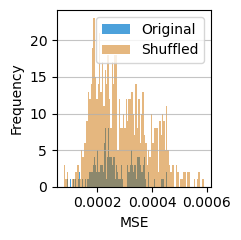

In [73]:
plt.figure(figsize=(2.5, 2.5))

plt.hist(out_mean[torch.where(out_mean > 1e-12)], bins=100, color='#007acc', alpha=0.7, label='Original')

# Histogram for rand_out_mean with a different nice color
plt.hist(rand_out_mean[torch.where(rand_out_mean > 1e-12)], bins=100, color='#cc7000', alpha=0.5, label='Shuffled')

# Enhancements
plt.xlabel('MSE')  # Label for the x-axis
plt.ylabel('Frequency')  # Label for the y-axis
plt.legend()  # Add a legend to distinguish the histograms
plt.tight_layout()  # Adjust layout to not overlap items
plt.grid(axis='y', alpha=0.75)  # Add a grid for better readability, only on y-axis
plt.savefig('figures/hist.pdf')
plt.show()